In [1]:
from sys import path
path.append('..')
from OTSax import *
import matplotlib.pyplot as plt
from jax import random
import optax
key = random.PRNGKey(0)

Error in sys.excepthook:
Traceback (most recent call last):
  File "f:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1979, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'RuntimeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "f:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1981, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "f:\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "f:\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "f:\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 851, in structured_traceback
    assert etb is not None
AssertionError

Original exception was:
RuntimeE

### Define parameterised distribution functions

In [2]:
@jax.jit
def IonMax(v,vi,Ti,Ai):
    sig2 = Ti/(Ai*amu_eV)
    norm = jnp.sqrt(2*jnp.pi*sig2)
    return jnp.exp(-0.5*(v-vi)**2/sig2)/norm

@jax.jit
def DoubleIonMax(v,vi_1,Ti_1,vi_2,Ti_2,Ai):
    sig2 = Ti_1/(Ai*amu_eV)
    norm = jnp.sqrt(2*jnp.pi*sig2)
    Max1 = jnp.exp(-0.5*(v-vi_1)**2/sig2)/norm
    sig2 = Ti_2/(Ai*amu_eV)
    norm = jnp.sqrt(2*jnp.pi*sig2)
    Max2 = jnp.exp(-0.5*(v-vi_2)**2/sig2)/norm
    return Max1+Max2

### Create helper functions to calculate $S(k,\omega)$

In [22]:
def calc_skw_Max(inputs,electron_params,ion_params):
    omega,scattering_angle,omega_laser,Ai,flytab = inputs
    ne,Te,ve = electron_params
    vi,Ti = ion_params

    # Find ionisation from FLY table
    Z = flytab.interp(Te,ne)
    
    # Calculate S(k,w)
    skw_val = skw(omega,scattering_angle,omega_laser,Te*1e-3,Ti*1e-3,Z,Ai,ne,ve,vi)
    return skw_val

def calc_skw_nonMax(inputs,electron_params,ion_params):
    omega,scattering_angle,omega_laser,Ai,flytab = inputs
    ne,Te,ve = electron_params
    fion_params,fion_func = ion_params
    
    # Sample distribution function
    fion = create_dist_func_dict(fion_func,*fion_params)

    # Find ionisation from FLY table
    Z = flytab.interp(Te,ne)
    
    # Calculate S(k,w)
    Te_keV = Te*1e-3
    skw_val = skwic(omega,scattering_angle,omega_laser,Te_keV,Z,Ai,ne,ve,fion)
    return skw_val

### Set up laser and ion properties

In [23]:
# Laser parameters
laser_wavelength = 531.8e-9 # m
sa = 60.0 # Scattering angle in degrees

# Ion properties
Ai = 27.0
Zi = 13
flytab = IaeaTable(Zi)

# Numerical parameters
Nomg  = 2000
omgL  = c*2*jnp.pi/laser_wavelength
omg   = jnp.linspace(-0.001*omgL,0.001*omgL,Nomg)
wlsim_ang = 1e10*((2*jnp.pi*c)/(omg+omgL)-laser_wavelength)

### Maxwellian example, comparing Maxwellian and non-Maxwellian code

In [24]:
ne = 1e18
Te = 20.0
ve = 50.0e3/sc.c

vi = -50.0e3/sc.c
Ti = 20.0

inputs = omg,sa,omgL,Ai,flytab
electron_params = ne,Te,ve
max_ion_params = vi,Ti
nonmax_ion_params = [vi,Ti,Ai],IonMax

from time import time
# Allow JITing
skw_max = calc_skw_Max(inputs,electron_params,max_ion_params)
start = time()
skw_max = calc_skw_Max(inputs,electron_params,max_ion_params)
max_time = time()-start

# Allow JITing
skw_nonmax = calc_skw_nonMax(inputs,electron_params,nonmax_ion_params)
start = time()
skw_nonmax = calc_skw_nonMax(inputs,electron_params,nonmax_ion_params)
nonmax_time = time()-start

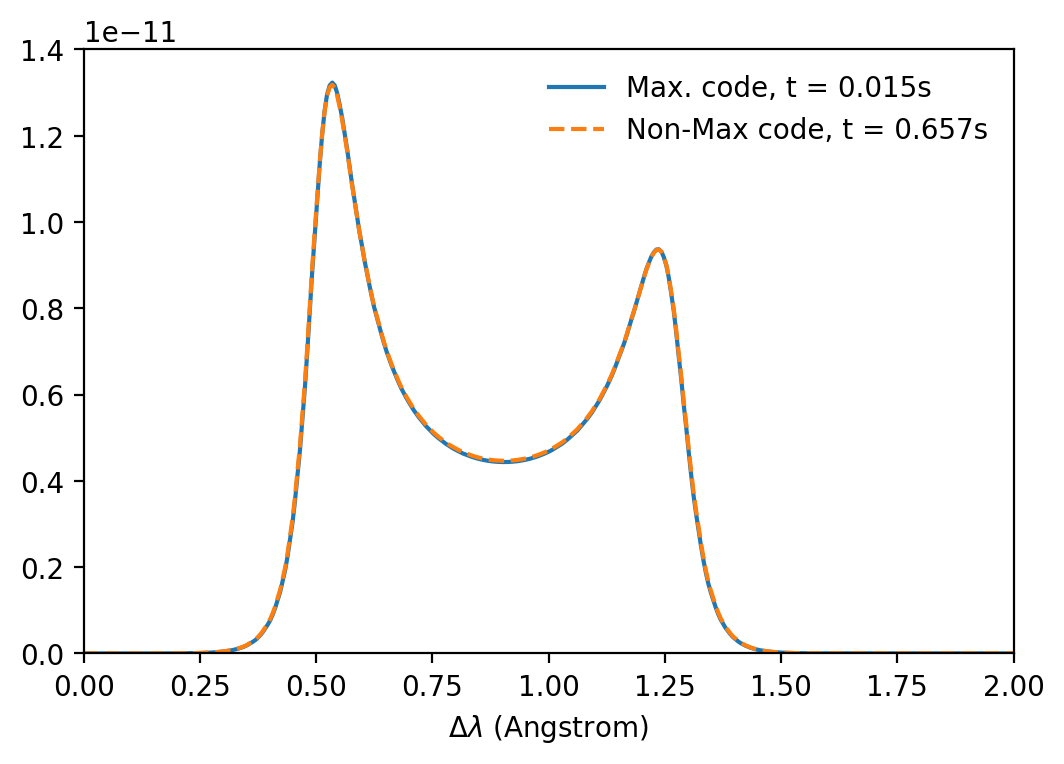

In [25]:
plt.figure(dpi=200)

plt.plot(wlsim_ang,skw_max,label=f'Max. code, t = {max_time:.3f}s')
plt.plot(wlsim_ang,skw_nonmax,ls='--',label=f'Non-Max code, t = {nonmax_time:.3f}s')

plt.legend(frameon=False)

plt.xlim(0.0,2.0)
plt.xlabel(r"$\Delta \lambda$ (Angstrom)")
plt.ylim(0.0,1.4e-11)

plt.show()

### Two Maxwellian example

In [7]:
ne = 1e18
Te = 20.0
ve = 00.0e3/sc.c

vi_1 = -50.0e3/sc.c
Ti_1 = 20.0

vi_2 = 0.0e3/sc.c
Ti_2 = 10.0

inputs = omg,sa,omgL,Ai,flytab
electron_params = ne,Te,ve
nonmax_ion_params = [vi_1,Ti_1,vi_2,Ti_2,Ai],DoubleIonMax

# Allow JITing
start = time()
skw_nonmax = calc_skw_nonMax(inputs,electron_params,nonmax_ion_params)
nonmax_time = time()-start

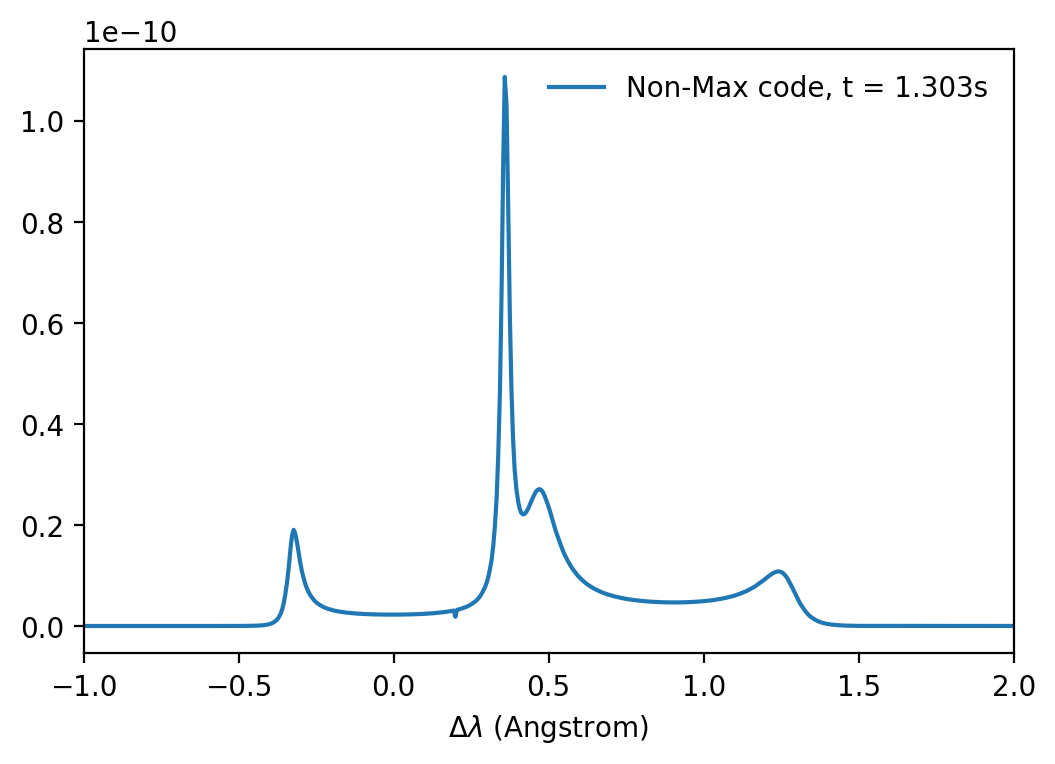

In [8]:
plt.figure(dpi=200)

plt.plot(wlsim_ang,skw_nonmax,label=f'Non-Max code, t = {nonmax_time:.3f}s')

plt.legend(frameon=False)

plt.xlim(-1.0,2.0)
plt.xlabel(r"$\Delta \lambda$ (Angstrom)")

plt.show()

### Example fitting a non-Maxwellian

In [9]:
# Create synthetic data
synthetic_data = skw_nonmax + 1e-12*jax.random.normal(key,shape=skw_nonmax.shape)

Create and initialise optimizer

In [10]:
vi_1,Ti_1,vi_2,Ti_2 = -60.0e3/c, 20.0, 0.0e3/c, 20.0
nonmax_ion_params = [vi_1,Ti_1,vi_2,Ti_2,Ai],DoubleIonMax
initial_skw_nonmax = calc_skw_nonMax(inputs,electron_params,nonmax_ion_params)

In [18]:
def create_piecewise_learning_rate_schedule(init_value,total_steps,decay_rate,boundaries):
    boundaries_and_scales = {int(total_steps*b) : decay_rate for b in boundaries}
    learning_rate_schedule = optax.piecewise_constant_schedule(init_value,boundaries_and_scales=boundaries_and_scales)
    return learning_rate_schedule

def LossFunc(params,scale_factor = 1e22):
    vi_1,Ti_1,vi_2,Ti_2 = params['vi_1'],params['Ti_1'],params['vi_2'],params['Ti_2']
    # Scaling
    vi_1 /= v_scale
    vi_2 /= v_scale
    nonmax_ion_params = [vi_1,Ti_1,vi_2,Ti_2,Ai],DoubleIonMax
    skw_nonmax = calc_skw_nonMax(inputs,electron_params,nonmax_ion_params)
    loss = scale_factor*jnp.mean((skw_nonmax-synthetic_data)**2)
    return loss

LossGradFunc = jax.value_and_grad(LossFunc)

noptsteps = 10
learning_rate_schedule = create_piecewise_learning_rate_schedule(0.25,noptsteps,0.5,[25,50,75])

optimizer = optax.adam(learning_rate=learning_rate_schedule)

# Initial values of fit parameters
v_scale = c/1e3
params = {'vi_1': vi_1*v_scale,'Ti_1' : Ti_1, 'vi_2' : vi_2*v_scale, 'Ti_2' : Ti_2}
opt_state = optimizer.init(params)

In [20]:
start = time()
_ = LossGradFunc(params)
print('Loss grad eval takes:',time()-start,'s')

Loss grad eval takes: 0.03418564796447754 s


In [14]:
loss_history = []
for i in range(noptsteps):
    print(i)
    loss, grad_loss = LossGradFunc(params)
    
    updates, opt_state = optimizer.update(grad_loss, opt_state)
    params = optax.apply_updates(params, updates)

    loss_history.append(loss)

0
1
2
3
4
5
6
7
8
9


{'Ti_1': Array(22.527763, dtype=float32), 'Ti_2': Array(22.118378, dtype=float32), 'vi_1': Array(-57.478878, dtype=float32), 'vi_2': Array(-2.1379669, dtype=float32)}


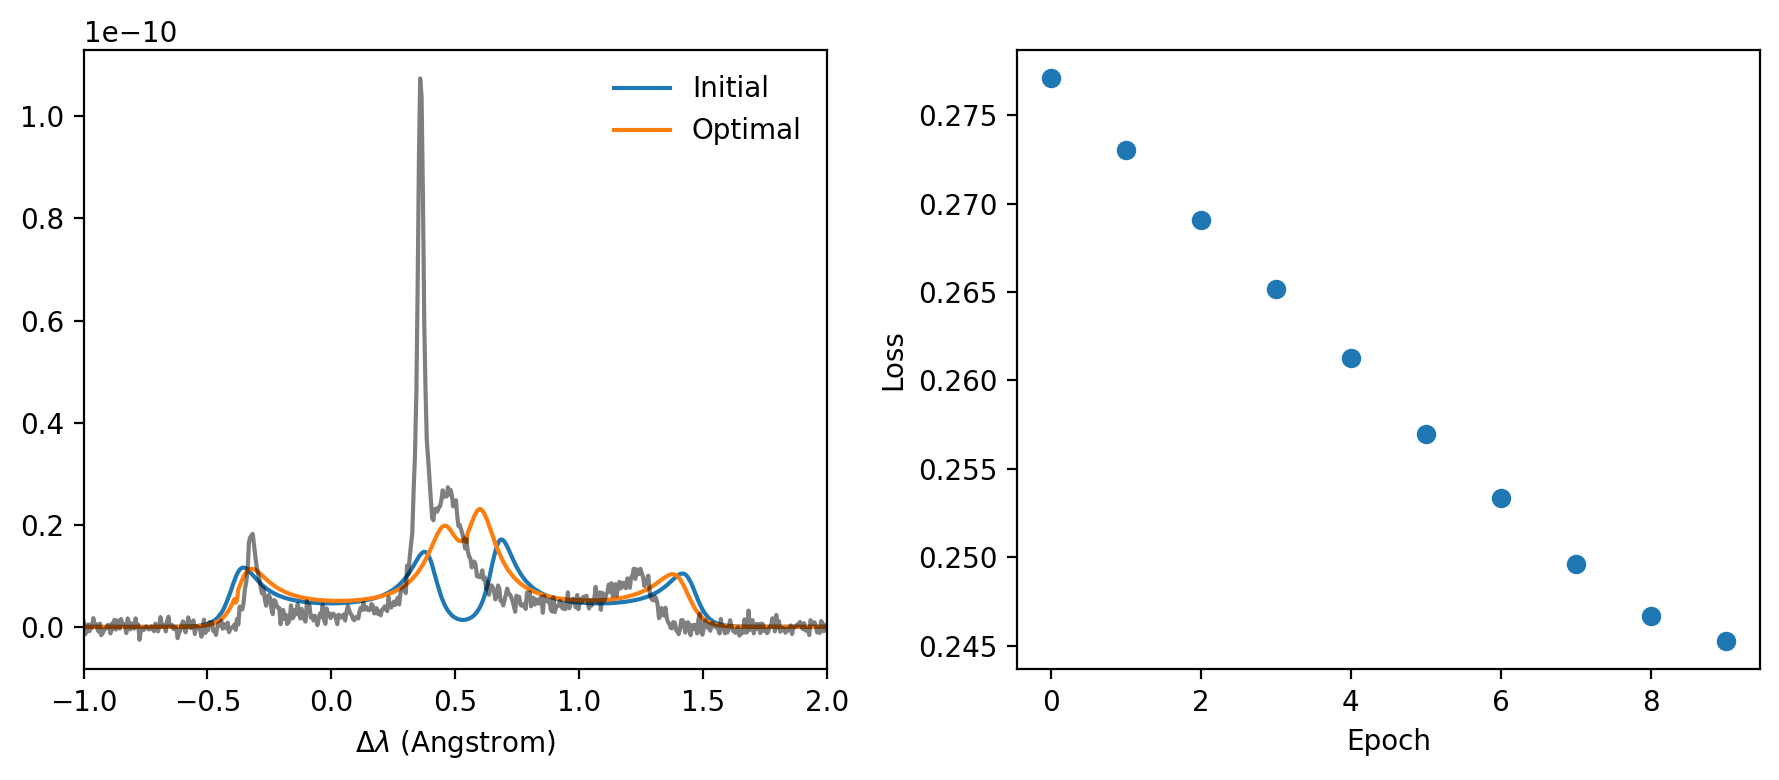

In [15]:
vi_1,Ti_1,vi_2,Ti_2 = params['vi_1'],params['Ti_1'],params['vi_2'],params['Ti_2']
print(params)
# Scaling
vi_1 /= v_scale
vi_2 /= v_scale
nonmax_ion_params = [vi_1,Ti_1,vi_2,Ti_2,Ai],DoubleIonMax
optimal_skw_nonmax = calc_skw_nonMax(inputs,electron_params,nonmax_ion_params)

fig = plt.figure(dpi=200,figsize=(9,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(wlsim_ang,initial_skw_nonmax,label='Initial')
ax1.plot(wlsim_ang,optimal_skw_nonmax,label='Optimal')
ax1.plot(wlsim_ang,synthetic_data,'k',alpha=0.5)

ax1.set_xlim(-1.0,2.0)
ax1.set_xlabel(r"$\Delta \lambda$ (Angstrom)")

ax1.legend(frameon=False)

ax2.scatter(jnp.arange(noptsteps),loss_history)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

fig.tight_layout()

plt.show()